# **MSDS 634: Introduction to Deep Learning - Final Project**
## Andrea Quiroz

In [4]:
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
import requests
import tarfile
import zipfile
import string
from sklearn.model_selection import train_test_split

# Arabic-specific libraries
import pyarabic.araby as araby
from pyarabic.normalize import normalize_searchtext
# For visualizations
import wordcloud
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("Environment setup complete!")

Environment setup complete!


# **Data Preprocessing**

## Data Acquisition

Make these folders within a data folder in the directory for this project:

In [5]:
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('data/raw/un_corpus', exist_ok=True)

In [6]:
def download_file(url, output_path):
    """Download a file from a URL to a specified path"""
    print(f"Downloading {url} to {output_path}")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    
    with open(output_path, 'wb') as file:
        for data in tqdm(response.iter_content(block_size),
                         total=total_size//block_size,
                         unit='KB', unit_scale=True):
            file.write(data)
    print(f"Download complete: {output_path}")

In [7]:
def combine_and_extract_split_files(file_prefix, parts, output_dir):
    """Combine split tar.gz files and extract them
    
    Args:
        file_prefix: The common prefix of the split files (e.g., 'UNv1.0.ar-es.tar.gz')
        parts: List of part extensions (e.g., ['00', '01'])
        output_dir: Directory to extract files to
    """
    # Combine the split files
    print(f"Combining split files with prefix {file_prefix}...")
    combined_file = os.path.join(output_dir, f"{file_prefix}.combined")
    with open(combined_file, 'wb') as outfile:
        for part in parts:
            part_file = os.path.join(output_dir, f"{file_prefix}.{part}")
            print(f"Adding part {part_file}")
            with open(part_file, 'rb') as infile:
                outfile.write(infile.read())
    
    # Extract the combined file
    print(f"Extracting combined file to {output_dir}...")
    with tarfile.open(combined_file, 'r:gz') as tar:
        tar.extractall(path=output_dir)
    
    # Remove the combined file to save space
    os.remove(combined_file)
    print("Extraction complete!")

### UN Parallel Corpus

What I originally did was I had everything within the same directory. 

In [8]:
un_corpus_dir = "data/raw/un_corpus"
os.makedirs(un_corpus_dir, exist_ok=True)

In [9]:
# File paths for the split tar.gz files
un_file_part1 = "UNv1.0.ar-es.tar.gz.00"
un_file_part2 = "UNv1.0.ar-es.tar.gz.01"

In [10]:
def verify_un_files():
    """Check if the UN corpus files exist and are ready for processing"""
    part1_exists = os.path.exists(un_file_part1)
    part2_exists = os.path.exists(un_file_part2)
    
    if part1_exists and part2_exists:
        print("Both UN corpus files are available.")
        print(f"  - {un_file_part1}")
        print(f"  - {un_file_part2}")
        return True
    elif part1_exists or part2_exists:
        print("Only one UN corpus file is available:")
        if part1_exists:
            print(f"  - {un_file_part1} (available)")
            print(f"  - {un_file_part2} (missing)")
        else:
            print(f"  - {un_file_part1} (missing)")
            print(f"  - {un_file_part2} (available)")
        return False
    else:
        print("UN corpus files not found. Please upload them to your Jupyter environment.")
        print(f"  - {un_file_part1}")
        print(f"  - {un_file_part2}")
        return False

In [11]:
# Verify UN files
un_files_ready = verify_un_files()

Both UN corpus files are available.
  - UNv1.0.ar-es.tar.gz.00
  - UNv1.0.ar-es.tar.gz.01


In [12]:
def process_un_corpus():
    """Process the UN corpus files by combining and extracting them"""
    if not un_files_ready:
        print("UN corpus files not ready for processing.")
        return
    
    print("Processing UN corpus files...")
    
    # 1. Combine the split files
    print("Combining split tar.gz files...")
    combined_tar = "UNv1.0.ar-es.tar.gz"
    with open(combined_tar, 'wb') as outfile:
        for part in [un_file_part1, un_file_part2]:
            with open(part, 'rb') as infile:
                outfile.write(infile.read())
    
    # 2. Extract the combined file
    print("Extracting combined tar.gz file...")
    with tarfile.open(combined_tar, 'r:gz') as tar:
        tar.extractall(path=un_corpus_dir)
    
    # 3. Clean up the combined file (optional)
    os.remove(combined_tar)
    print("Extraction complete!")
    
    # 4. Locate the extracted files
    es_file = None
    ar_file = None
    
    for root, _, files in os.walk(un_corpus_dir):
        for file in files:
            if file.endswith(".es"):
                es_file = os.path.join(root, file)
            elif file.endswith(".ar"):
                ar_file = os.path.join(root, file)
    
    if es_file and ar_file:
        print(f"Found extracted files:")
        print(f"  - Spanish: {es_file}")
        print(f"  - Arabic: {ar_file}")
        return es_file, ar_file
    else:
        print("Could not find extracted Spanish and Arabic files.")
        return None, None

In [13]:
es_file, ar_file = process_un_corpus()

Processing UN corpus files...
Combining split tar.gz files...
Extracting combined tar.gz file...
Extraction complete!
Found extracted files:
  - Spanish: data/raw/un_corpus/ar-es/UNv1.0.ar-es.es
  - Arabic: data/raw/un_corpus/ar-es/UNv1.0.ar-es.ar


In [14]:
# Function to read UN corpus data
def read_un_corpus(es_file, ar_file, max_lines=10000, random_sample=True):
    """Read the UN corpus parallel data
    
    Args:
        es_file: Path to Spanish file
        ar_file: Path to Arabic file
        max_lines: Maximum number of lines to read
        random_sample: Whether to take a random sample or the first max_lines
        
    Returns:
        DataFrame with spanish and arabic columns
    """
    if not es_file or not ar_file:
        print("Spanish or Arabic file path is missing.")
        return None
    
    try:
        # Read all lines from both files
        with open(es_file, 'r', encoding='utf-8') as es_f, \
             open(ar_file, 'r', encoding='utf-8') as ar_f:
            es_lines = es_f.readlines()
            ar_lines = ar_f.readlines()
            
        # Ensure the files have the same number of lines
        if len(es_lines) != len(ar_lines):
            print(f"Warning: Files have different number of lines. Spanish: {len(es_lines)}, Arabic: {len(ar_lines)}")
            min_lines = min(len(es_lines), len(ar_lines))
            es_lines = es_lines[:min_lines]
            ar_lines = ar_lines[:min_lines]
        
        total_lines = len(es_lines)
        print(f"Total lines in UN corpus: {total_lines}")
        
        # Sample the data
        if max_lines >= total_lines:
            selected_indices = range(total_lines)
        elif random_sample:
            selected_indices = random.sample(range(total_lines), max_lines)
        else:
            selected_indices = range(max_lines)
        
        # Create pairs
        pairs = []
        for idx in selected_indices:
            es = es_lines[idx].strip()
            ar = ar_lines[idx].strip()
            if es and ar:  # Skip empty lines
                pairs.append((es, ar))
        
        # Create DataFrame
        df = pd.DataFrame(pairs, columns=['spanish', 'arabic'])
        df['source'] = 'un_corpus'
        df['dialect'] = 'standard'  # UN documents use standard Spanish
        
        print(f"Loaded {len(df)} sentence pairs from UN corpus.")
        return df
    
    except Exception as e:
        print(f"Error reading UN corpus: {e}")
        return None

In [20]:
if os.path.exists(es_file) and os.path.exists(ar_file):
    print(f"✅ Using real UN Corpus data from:")
    print(f"  - Spanish: {es_file}")
    print(f"  - Arabic: {ar_file}")
    
    # Set sample size for development (increase for final training)
    sample_size = 10000
    
    # Read lines from both files
    with open(es_file, 'r', encoding='utf-8') as es_f, \
         open(ar_file, 'r', encoding='utf-8') as ar_f:
        es_lines = es_f.readlines()
        ar_lines = ar_f.readlines()
    
    # Sample the data
    indices = random.sample(range(len(es_lines)), min(sample_size, len(es_lines)))
    pairs = [(es_lines[i].strip(), ar_lines[i].strip()) for i in indices 
             if es_lines[i].strip() and ar_lines[i].strip()]
    
    # Create the DataFrame with real data
    un_df = pd.DataFrame(pairs, columns=['spanish', 'arabic'])
    un_df['source'] = 'un_corpus'  # Mark as real UN data
    un_df['dialect'] = 'standard'
    
    print(f"Successfully loaded {len(un_df)} sentence pairs from real UN Corpus")
else:
    # Fall back to sample data only if files not found
    print("❌ UN Corpus files not found. Using sample data instead.")

✅ Using real UN Corpus data from:
  - Spanish: data/raw/un_corpus/ar-es/UNv1.0.ar-es.es
  - Arabic: data/raw/un_corpus/ar-es/UNv1.0.ar-es.ar
Successfully loaded 10000 sentence pairs from real UN Corpus


In [26]:
un_df

,spanish,arabic,source,dialect
0,La política macroeconómica (tipos de cambio y ...,ذلك أن سياسات اﻻقتصاد الكلي )أسعار الصرف والسي...,un_corpus,standard
1,80. Los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيئية آلية ممكنة لتنمية الرعا...,un_corpus,standard
2,Decreto Presidencial No. 4.086 del 16.11.05 (G...,المرسوم الرئاسي رقم 4086 المؤرخ 16 تشرين الثان...,un_corpus,standard
3,Côte d'Ivoire (15 de marzo de 2004),جمهورية الكونغو الديمقراطية (12 شباط/فبراير 2004),un_corpus,standard
4,Sistema de preparación de seguridad elaborado ...,استحداث نظام التأهب الأمني في آب/أغسطس 2003,un_corpus,standard
...,...,...,...,...
9995,El Sr. KOBAYASHI (Japón) destaca la trascenden...,٤١ - السيد كوباياشي )اليابان(: أكد على أهمية ا...,un_corpus,standard
9996,- La presunta relación que un individuo pueda ...,- ما يدعى وجوده من علاقة للشخص بقضايا أخرى,un_corpus,standard
9997,"17. El 4 de septiembre de 1992, un grupo de co...",٧١ - في ٤ أيلول/سبتمبر ٢٩٩١، عبر أعداء الثورة ...,un_corpus,standard
9998,El segundo período de sesiones del Grupo Inter...,وكانت الدورة الثانية لفريق الخبراء الحكومي الد...,un_corpus,standard


In [15]:
opensubtitles_es_file = "OpenSubtitles.ar-es.es"
opensubtitles_ar_file = "OpenSubtitles.ar-es.ar"

In [16]:
def verify_opensubtitles_files():
    """Check if the OpenSubtitles files exist and are ready for processing"""
    es_exists = os.path.exists(opensubtitles_es_file)
    ar_exists = os.path.exists(opensubtitles_ar_file)
    
    if es_exists and ar_exists:
        print("Both OpenSubtitles files are available.")
        print(f"  - {opensubtitles_es_file}")
        print(f"  - {opensubtitles_ar_file}")
        return True
    elif es_exists or ar_exists:
        print("Only one OpenSubtitles file is available:")
        if es_exists:
            print(f"  - {opensubtitles_es_file} (available)")
            print(f"  - {opensubtitles_ar_file} (missing)")
        else:
            print(f"  - {opensubtitles_es_file} (missing)")
            print(f"  - {opensubtitles_ar_file} (available)")
        return False
    else:
        print("OpenSubtitles files not found. Please upload them to your Jupyter environment.")
        print(f"  - {opensubtitles_es_file}")
        print(f"  - {opensubtitles_ar_file}")
        return False

In [17]:
opensubtitles_files_ready = verify_opensubtitles_files()

Both OpenSubtitles files are available.
  - OpenSubtitles.ar-es.es
  - OpenSubtitles.ar-es.ar


In [30]:
def read_opensubtitles(es_file, ar_file, max_lines=10000, min_words=3, max_words=40, random_sample=True):
    """Read the OpenSubtitles parallel data with filtering
    
    Args:
        es_file: Path to Spanish file
        ar_file: Path to Arabic file
        max_lines: Maximum number of lines to read
        min_words: Minimum number of words in both source and target
        max_words: Maximum number of words in both source and target
        random_sample: Whether to take a random sample or the first max_lines
        
    Returns:
        DataFrame with spanish and arabic columns
    """
    if not os.path.exists(es_file) or not os.path.exists(ar_file):
        print("OpenSubtitles files not found. Please upload them first.")
        return None
    
    try:
        pairs = []
        skipped = 0
        total_lines = 0
        
        # Read all lines from both files
        with open(es_file, 'r', encoding='utf-8') as es_f, \
             open(ar_file, 'r', encoding='utf-8') as ar_f:
            es_lines = es_f.readlines()
            ar_lines = ar_f.readlines()
            
        # Ensure the files have the same number of lines
        if len(es_lines) != len(ar_lines):
            print(f"Warning: Files have different number of lines. Spanish: {len(es_lines)}, Arabic: {len(ar_lines)}")
            min_lines = min(len(es_lines), len(ar_lines))
            es_lines = es_lines[:min_lines]
            ar_lines = ar_lines[:min_lines]
        
        total_lines = len(es_lines)
        print(f"Total lines in OpenSubtitles corpus: {total_lines}")
        
        # Sample the data
        if max_lines >= total_lines:
            selected_indices = range(total_lines)
        elif random_sample:
            selected_indices = random.sample(range(total_lines), max_lines)
        else:
            selected_indices = range(max_lines)
        
        # Process selected lines
        for idx in selected_indices:
            es = es_lines[idx].strip()
            ar = ar_lines[idx].strip()
            
            # Skip empty lines
            if not es or not ar:
                skipped += 1
                continue
            
            # Apply length filters
            es_word_count = len(es.split())
            ar_word_count = len(ar.split())
            
            if (min_words <= es_word_count <= max_words and 
                min_words <= ar_word_count <= max_words):
                pairs.append((es, ar))
            else:
                skipped += 1
        
        # Create DataFrame
        df = pd.DataFrame(pairs, columns=['spanish', 'arabic'])
        df['source'] = 'opensubtitles'
        df['dialect'] = 'unknown'  # We'll assign dialects later
        
        print(f"Loaded {len(df)} valid sentence pairs from OpenSubtitles. Skipped {skipped} pairs.")
        return df
    
    except Exception as e:
        print(f"Error reading OpenSubtitles corpus: {e}")
        return None

In [31]:
opensubtitles_df = read_opensubtitles(opensubtitles_es_file, opensubtitles_ar_file)

Total lines in OpenSubtitles corpus: 59926972
Loaded 7344 valid sentence pairs from OpenSubtitles. Skipped 2656 pairs.


In [32]:
opensubtitles_es_file = "OpenSubtitles.ar-es.es"  # Path to Spanish subtitles file
opensubtitles_ar_file = "OpenSubtitles.ar-es.ar"  # Path to Arabic subtitles file

Using OpenSubtitles files found at:
  - Spanish: OpenSubtitles.ar-es.es
  - Arabic: OpenSubtitles.ar-es.ar
Total lines in OpenSubtitles corpus: 59926972
Loaded 7316 valid sentence pairs from OpenSubtitles. Skipped 2684 pairs.
Successfully loaded 7316 sentence pairs from OpenSubtitles.

OpenSubtitles Examples:
Spanish: Ya esta aqui, vete a recibirle, venga!
Arabic: ‫ها هو ذا. اذهب واستقبله.
--------------------------------------------------
Spanish: Ya se jubiló.
Arabic: نعم ، لقد تقاعد
--------------------------------------------------
Spanish: Yo no le dije nada a nadie.
Arabic: لم أخبر أحدا بالأمر
--------------------------------------------------
Spanish: Hoy se ve en verdad rojo.
Arabic: يبدو وجهك أحمر للغاية اليوم.
--------------------------------------------------
Spanish: Que no puedas tocar no significa que no puedas disfrutar.
Arabic: ليس لأنك لا تستطيع اللمس يعني أنك لا تستطيع الاستمتاع
--------------------------------------------------


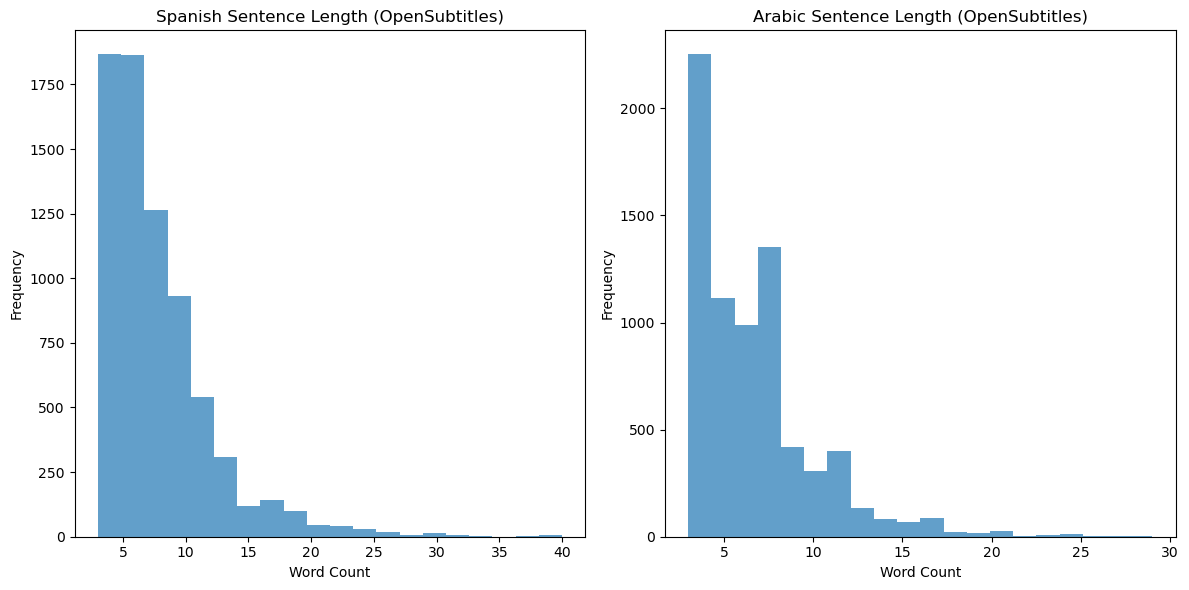

In [35]:
if os.path.exists(opensubtitles_es_file) and os.path.exists(opensubtitles_ar_file):
    print(f"Using OpenSubtitles files found at:")
    print(f"  - Spanish: {opensubtitles_es_file}")
    print(f"  - Arabic: {opensubtitles_ar_file}")
    
    # Set sampling parameters
    # During development, use a smaller sample to speed up processing
    sample_size = 10000  # Adjust as needed
    min_words = 3       # Filter out very short sentences
    max_words = 40      # Filter out very long sentences
    random_sample = True # Use random sampling rather than just taking the first N lines
    
    # Load the data from OpenSubtitles
    opensubtitles_df = read_opensubtitles(
        opensubtitles_es_file, 
        opensubtitles_ar_file,
        max_lines=sample_size,
        min_words=min_words,
        max_words=max_words,
        random_sample=random_sample
    )
    
    if opensubtitles_df is not None:
        print(f"Successfully loaded {len(opensubtitles_df)} sentence pairs from OpenSubtitles.")
        
        # Display a few examples
        print("\nOpenSubtitles Examples:")
        display_subset = opensubtitles_df.head(5)
        for i, row in display_subset.iterrows():
            print(f"Spanish: {row['spanish']}")
            print(f"Arabic: {row['arabic']}")
            print("-" * 50)
            
        # Analyze sentence lengths
        opensubtitles_df['spanish_word_count'] = opensubtitles_df['spanish'].apply(lambda x: len(x.split()))
        opensubtitles_df['arabic_word_count'] = opensubtitles_df['arabic'].apply(lambda x: len(x.split()))
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(opensubtitles_df['spanish_word_count'], bins=20, alpha=0.7)
        plt.title('Spanish Sentence Length (OpenSubtitles)')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(opensubtitles_df['arabic_word_count'], bins=20, alpha=0.7)
        plt.title('Arabic Sentence Length (OpenSubtitles)')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    else:
        # Fall back to sample data if there was an error reading the corpus
        print("Error reading OpenSubtitles files. Using sample data instead.")
        opensubtitles_sample_data = [
            ("¿Cómo estás hoy?", "كيف حالك اليوم؟"),
            ("No puedo creer que hiciste eso.", "لا أستطيع أن أصدق أنك فعلت ذلك."),
            ("Necesito hablar contigo ahora mismo.", "أحتاج إلى التحدث معك الآن."),
            ("¿Dónde están mis llaves?", "أين مفاتيحي؟"),
            ("Te extrañé mucho.", "اشتقت إليك كثيرا."),
            ("¿Quieres ir al cine?", "هل تريد الذهاب إلى السينما؟"),
            ("Eso fue muy divertido.", "كان ذلك مضحكا جدا."),
            ("No entiendo lo que dices.", "لا أفهم ما تقول."),
            ("Tenemos que irnos ahora.", "علينا أن نذهب الآن."),
            ("¿Qué piensas sobre esta idea?", "ما رأيك في هذه الفكرة؟")
        ]
        
        # Create sample DataFrame
        opensubtitles_df = pd.DataFrame(opensubtitles_sample_data, columns=['spanish', 'arabic'])
        opensubtitles_df['source'] = 'opensubtitles_sample'
        opensubtitles_df['dialect'] = 'unknown'
        print(f"OpenSubtitles sample loaded: {len(opensubtitles_df)} sentence pairs")
else:
    print("OpenSubtitles files not found at the expected paths:")
    print(f"  - Spanish: {opensubtitles_es_file}")
    print(f"  - Arabic: {opensubtitles_ar_file}")
    print("Using sample data instead.")
    
    # Create sample data as fallback
    opensubtitles_sample_data = [
        ("¿Cómo estás hoy?", "كيف حالك اليوم؟"),
        ("No puedo creer que hiciste eso.", "لا أستطيع أن أصدق أنك فعلت ذلك."),
        ("Necesito hablar contigo ahora mismo.", "أحتاج إلى التحدث معك الآن."),
        ("¿Dónde están mis llaves?", "أين مفاتيحي؟"),
        ("Te extrañé mucho.", "اشتقت إليك كثيرا."),
        ("¿Quieres ir al cine?", "هل تريد الذهاب إلى السينما؟"),
        ("Eso fue muy divertido.", "كان ذلك مضحكا جدا."),
        ("No entiendo lo que dices.", "لا أفهم ما تقول."),
        ("Tenemos que irnos ahora.", "علينا أن نذهب الآن."),
        ("¿Qué piensas sobre esta idea?", "ما رأيك في هذه الفكرة؟")
    ]
    
    # Create sample DataFrame
    opensubtitles_df = pd.DataFrame(opensubtitles_sample_data, columns=['spanish', 'arabic'])
    opensubtitles_df['source'] = 'opensubtitles_sample'
    opensubtitles_df['dialect'] = 'unknown'
    print(f"OpenSubtitles sample loaded: {len(opensubtitles_df)} sentence pairs")

In [34]:
opensubtitles_df

,spanish,arabic,source,dialect,spanish_word_count,arabic_word_count
0,¿Qué quieres para cenar?,‫ماذا تريد على العشاء؟,opensubtitles,unknown,4,4
1,¿Suena esa carta triste como si hubiera sido e...,هل هذه الرسالة الحزينة تبدو وكأنها مكتوبة من ا...,opensubtitles,unknown,12,9
2,Y vigila la salida norte.,‏واحرس المخرج الشمالي.,opensubtitles,unknown,5,3
3,Eres mi brújula moral.,انتي بوصلتي(رفيق الروح),opensubtitles,unknown,4,3
4,"Billy, ¿qué intentas hacer?","‫""بيلي""، ماذا تحاول أن تفعل؟",opensubtitles,unknown,4,5
...,...,...,...,...,...,...
7296,"Venga, te enseñaré la casa.",‫هيّا بنا، سأريك المنزل‬,opensubtitles,unknown,5,4
7297,"Dios mío, ha aprendido tres idiomas. ¿Cómo pod...",ياإلهي انه يعرف ثلاث لغات كيف يكون مفرط في نشا...,opensubtitles,unknown,10,11
7298,Ven más temprano la semana que viene y discuti...,‫احضري مبكرًا الأسبوع المقبل، ‬ ‫وسنناقش التفا...,opensubtitles,unknown,11,7
7299,"Vale, ¿dónde tienes que colocar las manos?","حسناً, إذاً, ما موضع اليدين الصحيح؟",opensubtitles,unknown,7,6


## Mexican Spanish Samples and Dialect Adaptation

These samples will be used for:
1. Identifying Mexican Spanish dialectal features
2. Creating a small test set for Mexican Spanish specific evaluation
3. Developing standardization rules for Mexican Spanish

In [36]:
# Since we're focusing on the UN Parallel Corpus and OpenSubtitles datasets,
# we'll create a small sample of Mexican Spanish examples for dialect adaptation

# Create a sample of Mexican Spanish specific phrases with standard equivalents
mexican_spanish_samples = [
    ("¿Qué onda, güey?", "¿Qué tal, amigo?", "ما أخبارك يا صديقي؟"),
    ("Está bien padre.", "Está muy bueno.", "إنه جيد جدا."),
    ("No manches.", "No me digas.", "لا تقل لي."),
    ("Ahorita vengo.", "Vuelvo enseguida.", "سأعود حالا."),
    ("Órale pues.", "Está bien.", "حسنا."),
    ("¿Qué pedo, carnal?", "¿Qué pasa, hermano?", "ماذا يحدث يا أخي؟"),
    ("La neta está chido.", "La verdad está genial.", "الحقيقة إنه رائع."),
    ("Ya me voy a mi chamba.", "Ya me voy a mi trabajo.", "أنا ذاهب إلى عملي الآن."),
    ("¿Vas a la fiesta? Está a toda madre.", "¿Vas a la fiesta? Está muy buena.", "هل ستذهب إلى الحفلة؟ إنها رائعة."),
    ("Ese güey está bien fresa.", "Ese tipo está muy presumido.", "هذا الشخص متكبر جدا.")
]

mexican_df = pd.DataFrame(mexican_spanish_samples, 
                        columns=['mexican_spanish', 'standard_spanish', 'arabic'])
print(f"Mexican Spanish sample loaded: {len(mexican_df)} sentence pairs")

# We'll also use this approach to identify Mexican Spanish patterns in the OpenSubtitles dataset
print("\nNote: We'll use the dialect detection techniques to identify potential Mexican Spanish")
print("content within the OpenSubtitles dataset, which may contain varied Spanish dialects.")

Mexican Spanish sample loaded: 10 sentence pairs

Note: We'll use the dialect detection techniques to identify potential Mexican Spanish
content within the OpenSubtitles dataset, which may contain varied Spanish dialects.


In [37]:
mexican_df

,mexican_spanish,standard_spanish,arabic
0,"¿Qué onda, güey?","¿Qué tal, amigo?",ما أخبارك يا صديقي؟
1,Está bien padre.,Está muy bueno.,إنه جيد جدا.
2,No manches.,No me digas.,لا تقل لي.
3,Ahorita vengo.,Vuelvo enseguida.,سأعود حالا.
4,Órale pues.,Está bien.,حسنا.
5,"¿Qué pedo, carnal?","¿Qué pasa, hermano?",ماذا يحدث يا أخي؟
6,La neta está chido.,La verdad está genial.,الحقيقة إنه رائع.
7,Ya me voy a mi chamba.,Ya me voy a mi trabajo.,أنا ذاهب إلى عملي الآن.
8,¿Vas a la fiesta? Está a toda madre.,¿Vas a la fiesta? Está muy buena.,هل ستذهب إلى الحفلة؟ إنها رائعة.
9,Ese güey está bien fresa.,Ese tipo está muy presumido.,هذا الشخص متكبر جدا.


### Combining Datasets

In [38]:
un_df['dialect'] = 'standard'
opensubtitles_df['dialect'] = 'standard'

# For the Mexican corpus, mark as Mexican dialect
mexican_combined_df = mexican_df[['mexican_spanish', 'arabic']].copy()
mexican_combined_df.columns = ['spanish', 'arabic']
mexican_combined_df['dialect'] = 'mexican'

# Standard Spanish from the Mexican corpus
mexican_standard_df = mexican_df[['standard_spanish', 'arabic']].copy()
mexican_standard_df.columns = ['spanish', 'arabic'] 
mexican_standard_df['dialect'] = 'standard'

# Combine all datasets
combined_df = pd.concat([
    un_df.assign(source='un'),
    opensubtitles_df.assign(source='opensubtitles')
])

# Reset index
combined_df.reset_index(drop=True, inplace=True)

# Calculate word counts for all entries in combined dataset
combined_df['spanish_word_count'] = combined_df['spanish'].apply(lambda x: len(str(x).split()))
combined_df['arabic_word_count'] = combined_df['arabic'].apply(lambda x: len(str(x).split()))

print(f"Combined dataset created with {len(combined_df)} entries")
print("Word counts calculated for all rows")
combined_df.head()

Combined dataset created with 17316 entries
Word counts calculated for all rows


,spanish,arabic,source,dialect,spanish_word_count,arabic_word_count
0,La política macroeconómica (tipos de cambio y ...,ذلك أن سياسات اﻻقتصاد الكلي )أسعار الصرف والسي...,un,standard,20,18
1,80. Los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيئية آلية ممكنة لتنمية الرعا...,un,standard,19,12
2,Decreto Presidencial No. 4.086 del 16.11.05 (G...,المرسوم الرئاسي رقم 4086 المؤرخ 16 تشرين الثان...,un,standard,27,31
3,Côte d'Ivoire (15 de marzo de 2004),جمهورية الكونغو الديمقراطية (12 شباط/فبراير 2004),un,standard,7,6
4,Sistema de preparación de seguridad elaborado ...,استحداث نظام التأهب الأمني في آب/أغسطس 2003,un,standard,10,7


## Text Normalization and Preprocessing

In [39]:
def normalize_spanish(text):
    """Normalize Spanish text"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    # Normalize punctuation
    text = re.sub(r'[¿¡]', '', text)  # Remove Spanish question/exclamation marks
    
    # Normalize specific characters
    text = text.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
    text = text.replace('ü', 'u').replace('ñ', 'n')
    
    return text

In [40]:
def normalize_spanish_keep_accents(text):
    """Normalize Spanish text but keep accent marks (for better translation)"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

In [41]:
# Apply normalizations while creating copies of the original text
combined_df['spanish_original'] = combined_df['spanish']
combined_df['arabic_original'] = combined_df['arabic']

In [42]:
# Create normalized versions
# For Spanish, keep accents for better translation
combined_df['spanish_normalized'] = combined_df['spanish'].apply(normalize_spanish_keep_accents)

# For Arabic, use the pyarabic normalize_searchtext function directly
# This function performs all necessary Arabic normalization steps
combined_df['arabic_normalized'] = combined_df['arabic'].apply(normalize_searchtext)

# Also create fully normalized versions of Spanish (without accents) for analysis
combined_df['spanish_fully_normalized'] = combined_df['spanish'].apply(normalize_spanish)

In [43]:
print("Normalization complete!")
print("Arabic normalization performed using pyarabic.normalize.normalize_searchtext")
combined_df[['spanish_original', 'spanish_normalized', 'spanish_fully_normalized', 'arabic_original', 'arabic_normalized']].head(3)

Normalization complete!
Arabic normalization performed using pyarabic.normalize.normalize_searchtext


,spanish_original,spanish_normalized,spanish_fully_normalized,arabic_original,arabic_normalized
0,La política macroeconómica (tipos de cambio y ...,la política macroeconómica (tipos de cambio y ...,la politica macroeconomica (tipos de cambio y ...,ذلك أن سياسات اﻻقتصاد الكلي )أسعار الصرف والسي...,ذلك ان سياسات الاقتصاد الكلي )اسعار الصرف والس...
1,80. Los fondos para el medio ambiente constitu...,80. los fondos para el medio ambiente constitu...,80. los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيئية آلية ممكنة لتنمية الرعا...,٨٠ - وللصناديق البيءيه اليه ممكنه لتنميه الرعا...
2,Decreto Presidencial No. 4.086 del 16.11.05 (G...,decreto presidencial no. 4.086 del 16.11.05 (g...,decreto presidencial no. 4.086 del 16.11.05 (g...,المرسوم الرئاسي رقم 4086 المؤرخ 16 تشرين الثان...,المرسوم الرءاسي رقم 4086 المءرخ 16 تشرين الثان...


### Mexican Spanish-Specific Preprocessing

In [44]:
# Create a more comprehensive dictionary of Mexican Spanish lexical markers
mexican_markers = {
    # Common Mexican slang and expressions
    'güey': 3, 'wey': 3, 'chavo': 2, 'chava': 2, 'órale': 3, 'ándale': 3, 'chale': 3,
    'padre': 2, 'padrísimo': 3, 'padrisimo': 3, 'chido': 3, 'sale': 1, 'neta': 3,
    'chilango': 3, 'chilanga': 3, 'defeño': 3, 'defeña': 3, 'no manches': 3, 'no mames': 3,
    'qué onda': 2, 'que onda': 2, 'cuate': 2, 'carnal': 2, 'mande': 2, 'ahorita': 1,
    'chamba': 2, 'chambear': 2, 'fresa': 1, 'gacho': 2, 'buena onda': 2, 'a poco': 2,
    'híjole': 3, 'hijole': 3, 'chingar': 3, 'está suave': 2, 'está cañón': 3, 'está canon': 3,
    
    # Mexican place names and culture references
    'México': 1, 'Mexico': 1, 'DF': 2, 'CDMX': 3, 'Guadalajara': 2, 'Monterrey': 2,
    'Chiapas': 2, 'Oaxaca': 2, 'Yucatán': 2, 'Jalisco': 2, 'Tijuana': 2, 'Cancún': 2,
    'Tequila': 1, 'Mezcal': 1, 'Chapultepec': 3, 'Zócalo': 3, 'Polanco': 3, 'Azteca': 1,
    'Pemex': 3, 'Televisa': 2, 'Chilangolandia': 3,
    
    # Mexican pronunciation patterns (in written form)
    'pos': 1, 'pus': 2, 'tons': 2, 'ira': 1, 'pa': 1, 'nel': 3,
    
    # Mexican government and institutional terms
    'PRI': 2, 'PAN': 1, 'PRD': 2, 'Morena': 1, 'INE': 2,
    
    # Mexican food terms
    'tacos': 1, 'quesadilla': 1, 'torta': 1, 'chilaquiles': 3, 'pozole': 3, 'tamales': 1,
    'enchiladas': 2, 'mole': 2, 'chiles': 1, 'nopal': 3, 'elote': 3, 'chapulines': 3,
    'carnitas': 2, 'barbacoa': 2, 'birria': 3
}

In [45]:
def score_mexican_spanish(text):
    """Score a text for Mexican Spanish markers
    
    Args:
        text: The Spanish text to analyze
        
    Returns:
        tuple: (score, matched_markers)
    """
    text_lower = text.lower()
    score = 0
    matched_markers = []
    
    for marker, weight in mexican_markers.items():
        if marker in text_lower:
            score += weight
            matched_markers.append(marker)
            
    return score, matched_markers

In [46]:
def classify_spanish_dialect(text, threshold=2):
    """Classify Spanish text as Mexican or Standard
    
    Args:
        text: The Spanish text to classify
        threshold: Minimum score to classify as Mexican
        
    Returns:
        str: 'mexican' or 'standard'
    """
    score, markers = score_mexican_spanish(text)
    return 'mexican' if score >= threshold else 'standard'

In [47]:
def standardize_mexican_spanish(text):
    """Convert Mexican Spanish slang to more standard forms"""
    normalized = text.lower()
    
    # Replace Mexican-specific terms with more standard equivalents
    replacements = {
        'güey': 'amigo',
        'wey': 'amigo',
        'chavo': 'muchacho',
        'chava': 'muchacha',
        'no manches': 'no me digas',
        'no mames': 'no puede ser',
        'qué onda': 'qué tal',
        'que onda': 'qué tal',
        'órale': 'de acuerdo',
        'orale': 'de acuerdo',
        'chido': 'genial',
        'padre': 'bueno',
        'padrísimo': 'excelente',
        'padrisimo': 'excelente',
        'neta': 'verdad',
        'chamba': 'trabajo',
        'chambear': 'trabajar',
        'mande': 'qué',
        'ahorita': 'ahora',
        'cuate': 'amigo',
        'carnal': 'hermano',
        'nel': 'no',
        'chilango': 'persona de Ciudad de México',
        'chale': 'vaya',
        'gacho': 'malo',
        'fresa': 'presumido'
    }
    
    for mexican, standard in replacements.items():
        pattern = r'\b' + re.escape(mexican) + r'\b'
        normalized = re.sub(pattern, standard, normalized)
    
    return normalized

In [48]:
# Apply dialect detection to the combined dataset
if 'dialect' not in combined_df.columns:
    combined_df['dialect'] = 'unknown'

In [49]:
combined_df

,spanish,arabic,source,dialect,spanish_word_count,arabic_word_count,spanish_original,arabic_original,spanish_normalized,arabic_normalized,spanish_fully_normalized
0,La política macroeconómica (tipos de cambio y ...,ذلك أن سياسات اﻻقتصاد الكلي )أسعار الصرف والسي...,un,standard,20,18,La política macroeconómica (tipos de cambio y ...,ذلك أن سياسات اﻻقتصاد الكلي )أسعار الصرف والسي...,la política macroeconómica (tipos de cambio y ...,ذلك ان سياسات الاقتصاد الكلي )اسعار الصرف والس...,la politica macroeconomica (tipos de cambio y ...
1,80. Los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيئية آلية ممكنة لتنمية الرعا...,un,standard,19,12,80. Los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيئية آلية ممكنة لتنمية الرعا...,80. los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيءيه اليه ممكنه لتنميه الرعا...,80. los fondos para el medio ambiente constitu...
2,Decreto Presidencial No. 4.086 del 16.11.05 (G...,المرسوم الرئاسي رقم 4086 المؤرخ 16 تشرين الثان...,un,standard,27,31,Decreto Presidencial No. 4.086 del 16.11.05 (G...,المرسوم الرئاسي رقم 4086 المؤرخ 16 تشرين الثان...,decreto presidencial no. 4.086 del 16.11.05 (g...,المرسوم الرءاسي رقم 4086 المءرخ 16 تشرين الثان...,decreto presidencial no. 4.086 del 16.11.05 (g...
3,Côte d'Ivoire (15 de marzo de 2004),جمهورية الكونغو الديمقراطية (12 شباط/فبراير 2004),un,standard,7,6,Côte d'Ivoire (15 de marzo de 2004),جمهورية الكونغو الديمقراطية (12 شباط/فبراير 2004),côte d'ivoire (15 de marzo de 2004),جمهوريه الكونغو الديمقراطيه (12 شباط/فبراير 2004),côte d'ivoire (15 de marzo de 2004)
4,Sistema de preparación de seguridad elaborado ...,استحداث نظام التأهب الأمني في آب/أغسطس 2003,un,standard,10,7,Sistema de preparación de seguridad elaborado ...,استحداث نظام التأهب الأمني في آب/أغسطس 2003,sistema de preparación de seguridad elaborado ...,استحداث نظام التاهب الامني في اب/اغسطس 2003,sistema de preparacion de seguridad elaborado ...
...,...,...,...,...,...,...,...,...,...,...,...
17311,Anteriormente en Billions...,في الحلقات السابقة...,opensubtitles,standard,3,3,Anteriormente en Billions...,في الحلقات السابقة...,anteriormente en billions...,في الحلقات السابقه...,anteriormente en billions...
17312,Quizá tenga que ver con encontrar a ese otro b...,ربما خطة ما للعثور على الطفل الأخر,opensubtitles,standard,10,7,Quizá tenga que ver con encontrar a ese otro b...,ربما خطة ما للعثور على الطفل الأخر,quizá tenga que ver con encontrar a ese otro b...,ربما خطه ما للعثور علا الطفل الاخر,quiza tenga que ver con encontrar a ese otro b...
17313,¿Por qué es importante?,لمَ هذا مهم؟,opensubtitles,standard,4,3,¿Por qué es importante?,لمَ هذا مهم؟,¿por qué es importante?,لم هذا مهم؟,por que es importante?
17314,"Nadie sospecharía de ti, vas a salir.",- كيف عرفت ذلك؟ - لن يشك بك أحد لأنك توشك أن تخرج,opensubtitles,standard,7,13,"Nadie sospecharía de ti, vas a salir.",- كيف عرفت ذلك؟ - لن يشك بك أحد لأنك توشك أن تخرج,"nadie sospecharía de ti, vas a salir.",- كيف عرفت ذلك؟ - لن يشك بك احد لانك توشك ان تخرج,"nadie sospecharia de ti, vas a salir."


In [50]:
# Identify Mexican Spanish in our datasets using the markers
# We'll only use this for dialect identification, not to add new data
for idx, row in combined_df.iterrows():
    if combined_df.loc[idx, 'dialect'] == 'unknown':
        combined_df.loc[idx, 'dialect'] = classify_spanish_dialect(row['spanish'])

In [51]:
# Analyze Mexican Spanish coverage
mexican_count = (combined_df['dialect'] == 'mexican').sum()
standard_count = (combined_df['dialect'] == 'standard').sum()
unknown_count = (combined_df['dialect'] == 'unknown').sum()

print(f"Mexican Spanish sentences: {mexican_count} ({mexican_count/len(combined_df)*100:.1f}%)")
print(f"Standard Spanish sentences: {standard_count} ({standard_count/len(combined_df)*100:.1f}%)")
print(f"Unknown dialect sentences: {unknown_count} ({unknown_count/len(combined_df)*100:.1f}%)")

Mexican Spanish sentences: 0 (0.0%)
Standard Spanish sentences: 17316 (100.0%)
Unknown dialect sentences: 0 (0.0%)


In [52]:
# Create standardized versions of Mexican Spanish
combined_df['spanish_standardized'] = combined_df['spanish_normalized']
mask = combined_df['dialect'] == 'mexican'
combined_df.loc[mask, 'spanish_standardized'] = combined_df.loc[mask, 'spanish_normalized'].apply(standardize_mexican_spanish)

In [53]:
# Display examples of Mexican Spanish identification and standardization
if mexican_count > 0:
    mexican_examples = combined_df[combined_df['dialect'] == 'mexican'].head(5)
    print("\nExamples of identified Mexican Spanish:")
    for i, row in mexican_examples.iterrows():
        score, markers = score_mexican_spanish(row['spanish'])
        print(f"Spanish: {row['spanish']}")
        print(f"Detected markers: {markers}")
        print(f"Standardized: {row['spanish_standardized']}")
        print("-" * 50)

In [54]:
combined_df

,spanish,arabic,source,dialect,spanish_word_count,arabic_word_count,spanish_original,arabic_original,spanish_normalized,arabic_normalized,spanish_fully_normalized,spanish_standardized
0,La política macroeconómica (tipos de cambio y ...,ذلك أن سياسات اﻻقتصاد الكلي )أسعار الصرف والسي...,un,standard,20,18,La política macroeconómica (tipos de cambio y ...,ذلك أن سياسات اﻻقتصاد الكلي )أسعار الصرف والسي...,la política macroeconómica (tipos de cambio y ...,ذلك ان سياسات الاقتصاد الكلي )اسعار الصرف والس...,la politica macroeconomica (tipos de cambio y ...,la política macroeconómica (tipos de cambio y ...
1,80. Los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيئية آلية ممكنة لتنمية الرعا...,un,standard,19,12,80. Los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيئية آلية ممكنة لتنمية الرعا...,80. los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيءيه اليه ممكنه لتنميه الرعا...,80. los fondos para el medio ambiente constitu...,80. los fondos para el medio ambiente constitu...
2,Decreto Presidencial No. 4.086 del 16.11.05 (G...,المرسوم الرئاسي رقم 4086 المؤرخ 16 تشرين الثان...,un,standard,27,31,Decreto Presidencial No. 4.086 del 16.11.05 (G...,المرسوم الرئاسي رقم 4086 المؤرخ 16 تشرين الثان...,decreto presidencial no. 4.086 del 16.11.05 (g...,المرسوم الرءاسي رقم 4086 المءرخ 16 تشرين الثان...,decreto presidencial no. 4.086 del 16.11.05 (g...,decreto presidencial no. 4.086 del 16.11.05 (g...
3,Côte d'Ivoire (15 de marzo de 2004),جمهورية الكونغو الديمقراطية (12 شباط/فبراير 2004),un,standard,7,6,Côte d'Ivoire (15 de marzo de 2004),جمهورية الكونغو الديمقراطية (12 شباط/فبراير 2004),côte d'ivoire (15 de marzo de 2004),جمهوريه الكونغو الديمقراطيه (12 شباط/فبراير 2004),côte d'ivoire (15 de marzo de 2004),côte d'ivoire (15 de marzo de 2004)
4,Sistema de preparación de seguridad elaborado ...,استحداث نظام التأهب الأمني في آب/أغسطس 2003,un,standard,10,7,Sistema de preparación de seguridad elaborado ...,استحداث نظام التأهب الأمني في آب/أغسطس 2003,sistema de preparación de seguridad elaborado ...,استحداث نظام التاهب الامني في اب/اغسطس 2003,sistema de preparacion de seguridad elaborado ...,sistema de preparación de seguridad elaborado ...
...,...,...,...,...,...,...,...,...,...,...,...,...
17311,Anteriormente en Billions...,في الحلقات السابقة...,opensubtitles,standard,3,3,Anteriormente en Billions...,في الحلقات السابقة...,anteriormente en billions...,في الحلقات السابقه...,anteriormente en billions...,anteriormente en billions...
17312,Quizá tenga que ver con encontrar a ese otro b...,ربما خطة ما للعثور على الطفل الأخر,opensubtitles,standard,10,7,Quizá tenga que ver con encontrar a ese otro b...,ربما خطة ما للعثور على الطفل الأخر,quizá tenga que ver con encontrar a ese otro b...,ربما خطه ما للعثور علا الطفل الاخر,quiza tenga que ver con encontrar a ese otro b...,quizá tenga que ver con encontrar a ese otro b...
17313,¿Por qué es importante?,لمَ هذا مهم؟,opensubtitles,standard,4,3,¿Por qué es importante?,لمَ هذا مهم؟,¿por qué es importante?,لم هذا مهم؟,por que es importante?,¿por qué es importante?
17314,"Nadie sospecharía de ti, vas a salir.",- كيف عرفت ذلك؟ - لن يشك بك أحد لأنك توشك أن تخرج,opensubtitles,standard,7,13,"Nadie sospecharía de ti, vas a salir.",- كيف عرفت ذلك؟ - لن يشك بك أحد لأنك توشك أن تخرج,"nadie sospecharía de ti, vas a salir.",- كيف عرفت ذلك؟ - لن يشك بك احد لانك توشك ان تخرج,"nadie sospecharia de ti, vas a salir.","nadie sospecharía de ti, vas a salir."


### Text-Length Analysis

In [55]:
combined_df['spanish_word_count'] = combined_df['spanish_normalized'].apply(lambda x: len(x.split()))
combined_df['arabic_word_count'] = combined_df['arabic_normalized'].apply(lambda x: len(x.split()))
combined_df['spanish_char_count'] = combined_df['spanish_normalized'].apply(len)
combined_df['arabic_char_count'] = combined_df['arabic_normalized'].apply(len)

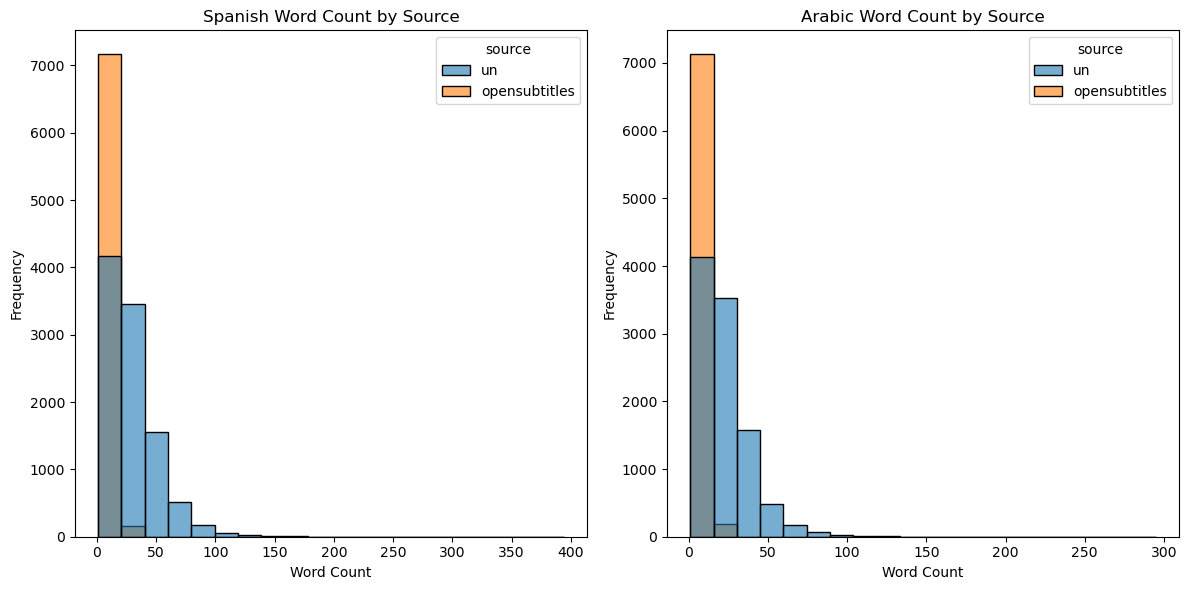

In [56]:
# Plot word count distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=combined_df, x='spanish_word_count', hue='source', alpha=0.6, bins=20)
plt.title('Spanish Word Count by Source')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data=combined_df, x='arabic_word_count', hue='source', alpha=0.6, bins=20)
plt.title('Arabic Word Count by Source')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

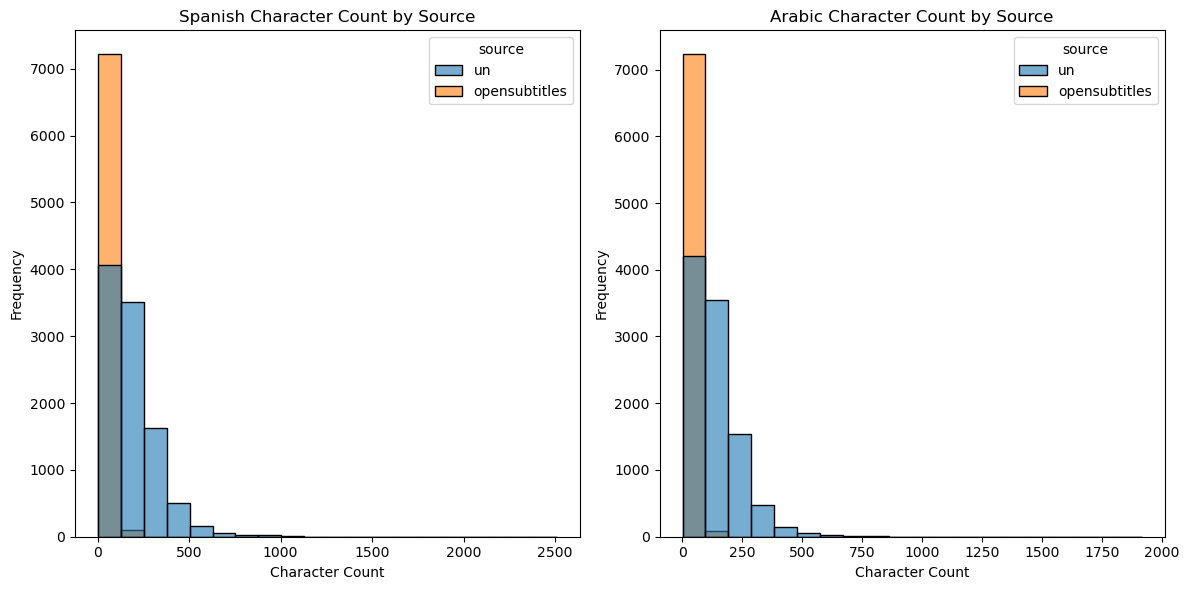

In [57]:
# Plot character count distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=combined_df, x='spanish_char_count', hue='source', alpha=0.6, bins=20)
plt.title('Spanish Character Count by Source')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data=combined_df, x='arabic_char_count', hue='source', alpha=0.6, bins=20)
plt.title('Arabic Character Count by Source')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

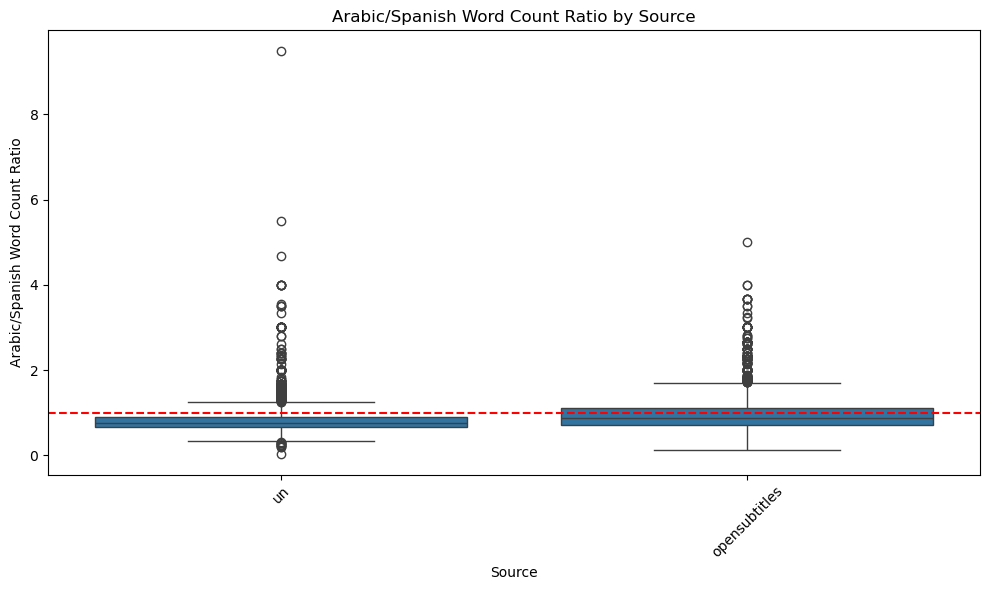

In [58]:
# Compare word count ratios
combined_df['word_count_ratio'] = combined_df['arabic_word_count'] / combined_df['spanish_word_count']

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='source', y='word_count_ratio')
plt.title('Arabic/Spanish Word Count Ratio by Source')
plt.xlabel('Source')
plt.ylabel('Arabic/Spanish Word Count Ratio')
plt.axhline(y=1, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Vocabulary Analysis

In [59]:
def get_vocabulary(texts):
    """Extract vocabulary from a series of texts"""
    all_words = []
    for text in texts:
        words = text.split()
        all_words.extend(words)
    return Counter(all_words)

In [60]:
# Get vocabularies
spanish_vocab = get_vocabulary(combined_df['spanish_normalized'])
arabic_vocab = get_vocabulary(combined_df['arabic_normalized'])
mexican_spanish_vocab = get_vocabulary(combined_df[combined_df['dialect'] == 'mexican']['spanish_normalized'])
standard_spanish_vocab = get_vocabulary(combined_df[combined_df['dialect'] == 'standard']['spanish_normalized'])

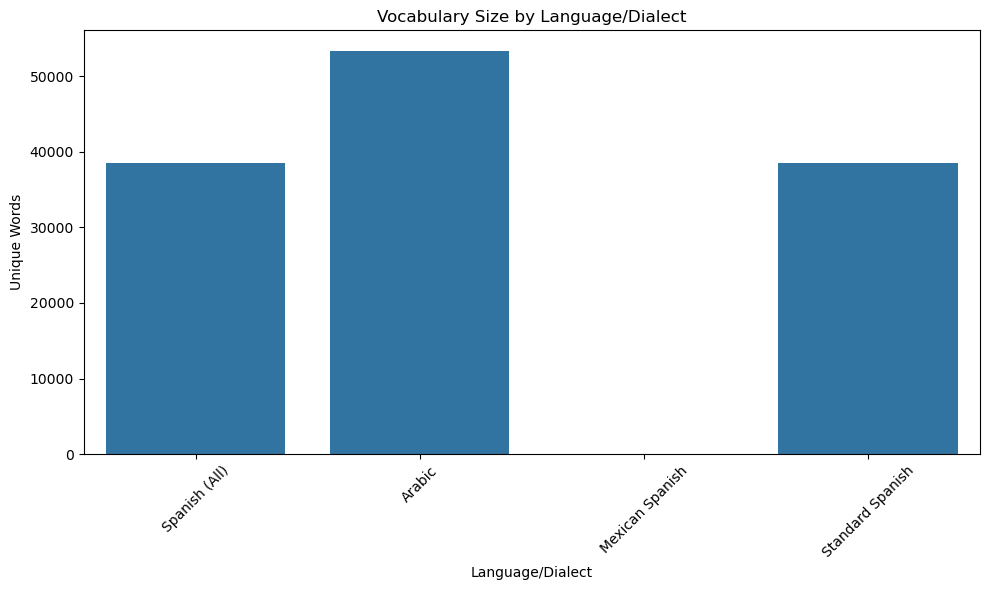

In [61]:
# Plot vocabulary sizes
vocab_sizes = {
    'Spanish (All)': len(spanish_vocab),
    'Arabic': len(arabic_vocab),
    'Mexican Spanish': len(mexican_spanish_vocab),
    'Standard Spanish': len(standard_spanish_vocab)
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(vocab_sizes.keys()), y=list(vocab_sizes.values()))
plt.title('Vocabulary Size by Language/Dialect')
plt.xlabel('Language/Dialect')
plt.ylabel('Unique Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

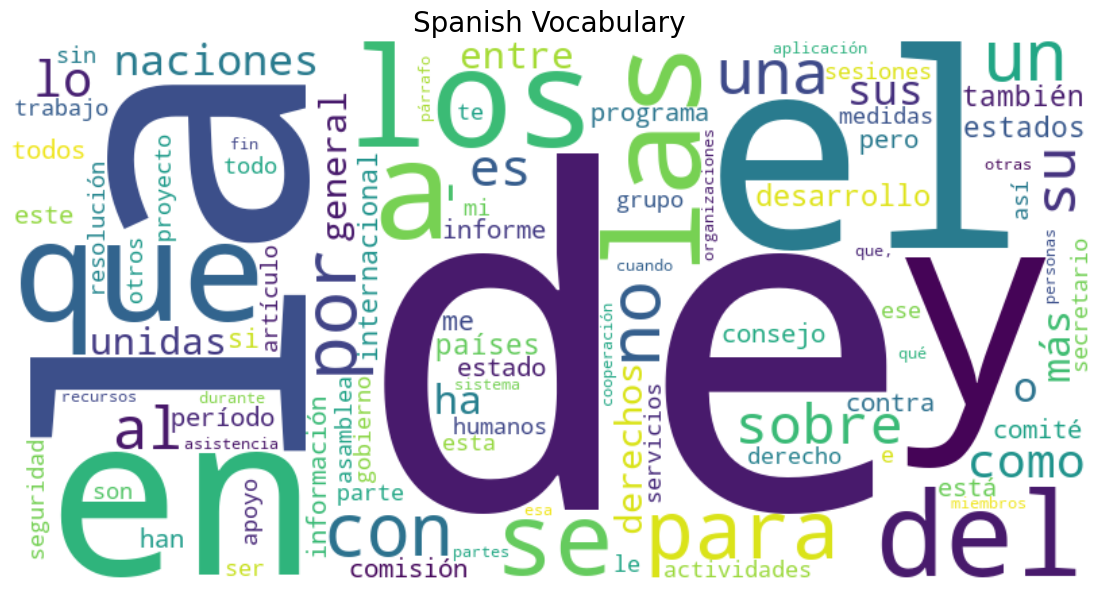

Top 20 Arabic words:
في: 8628
من: 5913
علا: 3620
ان: 3316
الا: 2973
-: 2582
التي: 1731
عن: 1504
لا: 1114
هذا: 1093
المتحده: 1010
او: 1010
الامم: 936
هذه: 919
ما: 891
مع: 782
ذلك: 781
الذي: 745
غير: 655
اللجنه: 632


In [63]:
plt.figure(figsize=(12, 6))
try:
    # Get top Spanish words
    top_spanish_words = dict(spanish_vocab.most_common(100))
    
    # Create Spanish word cloud
    spanish_wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100
    ).generate_from_frequencies(top_spanish_words)
    
    plt.imshow(spanish_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Spanish Vocabulary', fontsize=20)
    plt.tight_layout()
    plt.show()
    
    # Instead of visualizing Arabic with a word cloud, print the top words
    print("Top 20 Arabic words:")
    for word, count in arabic_vocab.most_common(20):
        print(f"{word}: {count}")
except Exception as e:
    print(f"Error creating word cloud: {e}")
    print("Skipping visualization and showing top words instead:")
    
    print("\nTop 20 Spanish words:")
    for word, count in spanish_vocab.most_common(20):
        print(f"{word}: {count}")
    
    print("\nTop 20 Arabic words:")
    for word, count in arabic_vocab.most_common(20):
        print(f"{word}: {count}")

### Dataset Splitting

In [64]:
# Prepare final dataset for model training
final_df = combined_df[['spanish_standardized', 'arabic_normalized']].copy()
final_df.columns = ['spanish', 'arabic']

In [65]:
final_df

,spanish,arabic
0,la política macroeconómica (tipos de cambio y ...,ذلك ان سياسات الاقتصاد الكلي )اسعار الصرف والس...
1,80. los fondos para el medio ambiente constitu...,٨٠ - وللصناديق البيءيه اليه ممكنه لتنميه الرعا...
2,decreto presidencial no. 4.086 del 16.11.05 (g...,المرسوم الرءاسي رقم 4086 المءرخ 16 تشرين الثان...
3,côte d'ivoire (15 de marzo de 2004),جمهوريه الكونغو الديمقراطيه (12 شباط/فبراير 2004)
4,sistema de preparación de seguridad elaborado ...,استحداث نظام التاهب الامني في اب/اغسطس 2003
...,...,...
17311,anteriormente en billions...,في الحلقات السابقه...
17312,quizá tenga que ver con encontrar a ese otro b...,ربما خطه ما للعثور علا الطفل الاخر
17313,¿por qué es importante?,لم هذا مهم؟
17314,"nadie sospecharía de ti, vas a salir.",- كيف عرفت ذلك؟ - لن يشك بك احد لانك توشك ان تخرج


In [66]:
# Split into train, validation, and test sets (80/10/10)
train_df, temp_df = train_test_split(final_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [67]:
print(f"Train set: {len(train_df)} examples ({len(train_df)/len(final_df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} examples ({len(val_df)/len(final_df)*100:.1f}%)")
print(f"Test set: {len(test_df)} examples ({len(test_df)/len(final_df)*100:.1f}%)")

Train set: 13852 examples (80.0%)
Validation set: 1732 examples (10.0%)
Test set: 1732 examples (10.0%)


In [68]:
# Save the datasets
train_df.to_csv('data/processed/train.csv', index=False)
val_df.to_csv('data/processed/val.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)

In [69]:
def display_samples(df, n=5):
    samples = df.sample(n, random_state=42)
    for i, row in samples.iterrows():
        print(f"Spanish: {row['spanish']}")
        print(f"Arabic: {row['arabic']}")
        print("-" * 50)

In [70]:
print("\nTrain set samples:")
display_samples(train_df)

print("\nValidation set samples:")
display_samples(val_df)

print("\nTest set samples:")
display_samples(test_df)


Train set samples:
Spanish: esta iluminación es increíble.
Arabic: هذه الاضاءه راءعه.
--------------------------------------------------
Spanish: porque necesitan algo en qué creer.
Arabic: ‫لانهم بحاجه للايمان بشيء ما.
--------------------------------------------------
Spanish: en ese contexto, el comité informó al estado parte de que, puesto que no había hecho ningún comentario sobre la información transmitida en mayo de 2013, el comité había decidido solicitar que algunos de sus miembros visitaran el país en noviembre de 2014.
Arabic: وفي ذلك السياق، ابلغت اللجنه الدوله الطرف بانها قررت ان تطلب قيام بعض اعضاءها بزياره لتلك الدوله في تشرين الثاني/نوفمبر 2014، نظرا لعدم تقديمها ايه ملاحظات علا المعلومات المحاله في ايار/ مايو 2013.
--------------------------------------------------
Spanish: el cumplimiento de los compromisos contraídos en 2011 seguirá siendo objeto de una atención particular y, cuando se logre, reforzará el marco jurídico en todo el mundo.
Arabic: وسيظل تنفيذ التعهدات